### The imports and global definitions:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, concatenate, UpSampling2D, Conv2DTranspose

In [2]:
from xrayproject import segmentation_DAM
from xrayproject.utils_DAM import load_train, load_masks
from xrayproject.preprocessing import normalize, flip_resize, resize_test

### Image-sizes for u-net processing and file-paths (preference for heights, widths in [96, 128, 160, 192, 224]):

In [3]:
path_image = '../raw_data/raw_PRC/CXR_png/'
path_mask = '../raw_data/raw_PRC/CXR_mask/'

In [4]:
preferred_sizes = [96, 128, 160, 192, 224]

IMG_HEIGHT = preferred_sizes[1]
IMG_WIDTH = IMG_HEIGHT

print((IMG_HEIGHT,IMG_WIDTH))

(128, 128)


### Importing the images and masks, resizing them to the appropriate values, and train-test-splitting:

In [42]:
masks, targets, ID = load_masks(100, get_all = False, get_random = True, balanced = True, path = path_mask)

Using path:  ../raw_data/raw_PRC/CXR_mask/
Using bucket 


In [43]:
images, IDs = load_train(ID, path = path_image)

In [44]:
resized = [flip_resize(images[i], masks[i], input_shape=(IMG_WIDTH, IMG_HEIGHT)) for i in range(len(images))]

In [45]:
X_1 = [img_mask_pair[0] for img_mask_pair in resized]
X_2 = [img_mask_pair[2] for img_mask_pair in resized]

Y_1 = [img_mask_pair[1] for img_mask_pair in resized]
Y_2 = [img_mask_pair[3] for img_mask_pair in resized]

X = X_1 + X_2
Y = Y_1 + Y_2

X = np.array(X)
Y = np.array(Y)

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [47]:
print(X_test.shape, X_train.shape)
print(Y_test.shape, Y_train.shape)

print(type(X_test), type(X_train))
print(type(Y_test), type(Y_train))

(60, 128, 128, 3) (140, 128, 128, 3)
(60, 128, 128, 1) (140, 128, 128, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Defining the u-net model, as copied from <https://www.kaggle.com/eduardomineo/u-net-lung-segmentation-montgomery-shenzhen>

In [48]:
def channels(x_train):
    return x_train.shape[-1]

IMG_CHANNELS = channels(X_train)

In [60]:
def to_img(lung_xray):
    pred_lung = unet_model.predict(lung_xray[tf.newaxis, ...]).squeeze()
    return pred_lung

In [49]:
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

### Instantiating the model, compiling it, and training it:

In [50]:
unet_model = unet()

In [51]:
unet_model.compile(optimizer='adam',
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [64]:
TRAIN_LENGTH = len(X_train)
EPOCHS = 5
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_model.fit(X_train,Y_train ,epochs=EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps = VALIDATION_STEPS,
                               validation_data=(X_test, Y_test))

Epoch 1/5
7/7 [==============================] - 33s 5s/step - loss: 0.2061 - accuracy: 0.9156
Epoch 2/5
7/7 [==============================] - 34s 5s/step - loss: 0.2016 - accuracy: 0.9176
Epoch 3/5
7/7 [==============================] - 34s 5s/step - loss: 0.1741 - accuracy: 0.9273
Epoch 4/5
7/7 [==============================] - 36s 5s/step - loss: 0.1690 - accuracy: 0.9314
Epoch 5/5
7/7 [==============================] - 39s 6s/step - loss: 0.1505 - accuracy: 0.9389


In [70]:
from tensorflow.keras.models import load_model
unet_model.save('1st_real_OK_unet')  # creates a HDF5 file 'my_model.h5'

INFO:tensorflow:Assets written to: 1st_real_OK_unet/assets


In [71]:
loaded_model = tf.keras.models.load_model('1st_real_OK_unet')

In [102]:
def to_img_gen(lung_xray, desired_model=unet_model):
    pred_lung = (1+np.sign(desired_model.predict(lung_xray[tf.newaxis, ...]).squeeze()-1/2))/2
    return pred_lung

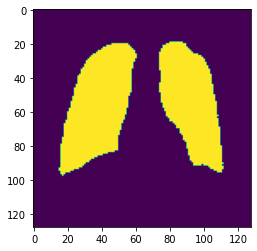

In [103]:
plt.imshow(to_img_gen(X_test[1],loaded_model))
plt.show()

### Instantiating the model again, compiling it, and training it on more epochs:

In [78]:
unet_model = unet()

In [79]:
unet_model.compile(optimizer='adam',
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [85]:
TRAIN_LENGTH = len(X_train)
EPOCHS = 15
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_model.fit(X_train,Y_train ,epochs=EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps = VALIDATION_STEPS,
                               validation_data=(X_test, Y_test))

Epoch 1/15
7/7 [==============================] - 34s 5s/step - loss: 0.1489 - accuracy: 0.9366
Epoch 2/15
7/7 [==============================] - 34s 5s/step - loss: 0.1421 - accuracy: 0.9399
Epoch 3/15
7/7 [==============================] - 35s 5s/step - loss: 0.1621 - accuracy: 0.9311
Epoch 4/15
7/7 [==============================] - 36s 5s/step - loss: 0.1402 - accuracy: 0.9418
Epoch 5/15
7/7 [==============================] - 35s 5s/step - loss: 0.1217 - accuracy: 0.9489
Epoch 6/15
7/7 [==============================] - 34s 5s/step - loss: 0.1152 - accuracy: 0.9535
Epoch 7/15
7/7 [==============================] - 36s 5s/step - loss: 0.1067 - accuracy: 0.9560
Epoch 8/15
7/7 [==============================] - 39s 6s/step - loss: 0.0946 - accuracy: 0.9613
Epoch 9/15
7/7 [==============================] - 36s 5s/step - loss: 0.0910 - accuracy: 0.9632
Epoch 10/15
7/7 [==============================] - 37s 5s/step - loss: 0.0916 - accuracy: 0.9627
Epoch 11/15
7/7 [======================

In [89]:
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [90]:
from tensorflow.keras.models import load_model
unet_model.save('2nd_real_OK_unet')  # creates a HDF5 file 'my_model.h5

loaded_model_better = tf.keras.models.load_model('2nd_real_OK_unet')

INFO:tensorflow:Assets written to: 2nd_real_OK_unet/assets


### Printing the image-outputs:

In [139]:
def to_img_gen(lung_xray, desired_model=unet_model, lung_threshold=1/2):
    pred_lung = (1+np.sign(desired_model.predict(lung_xray[tf.newaxis, ...]).squeeze()-(1-lung_threshold)))/2
    pred_lung = np.resize(pred_lung, (pred_lung.shape[0], pred_lung.shape[1], 1))
    return pred_lung

In [86]:
print(type(to_img(X_test[1])))
print(to_img(X_test[1]).max())
print(to_img(X_test[1]).min())

<class 'numpy.ndarray'>
0.9999959
6.5466885e-23


In [141]:
print(to_img_gen(X_test[1], loaded_model_better).max())
print(to_img_gen(X_test[1], loaded_model_better).min())
print(to_img_gen(X_test[1], loaded_model_better).mean())
print(type(to_img_gen(X_test[1], loaded_model_better)))
print(to_img_gen(X_test[1], loaded_model_better).shape)

1.0
0.0
0.25286865
<class 'numpy.ndarray'>
(128, 128, 1)


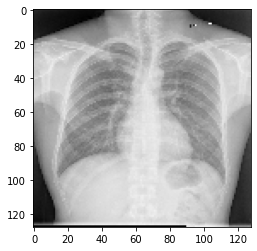

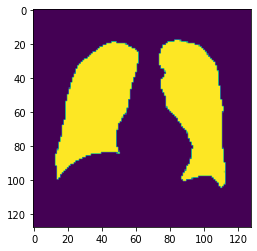

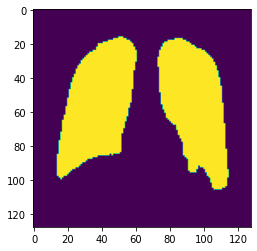

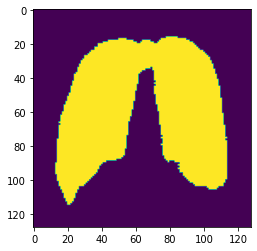

In [121]:
plt.imshow(X_test[1])
plt.show()

plt.imshow(Y_test[1])
plt.show()

plt.imshow(to_img_gen(X_test[1], loaded_model_better, 9/10))
plt.show()

plt.imshow(to_img_gen(X_test[1], loaded_model, 9/10))
plt.show()



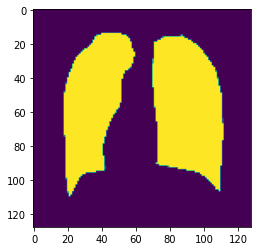

Difference between human-gen mask and model-gen mask with threshold = 11


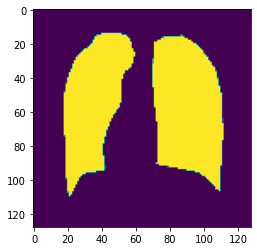

Difference between human-gen mask and model-gen mask with threshold = 0.8


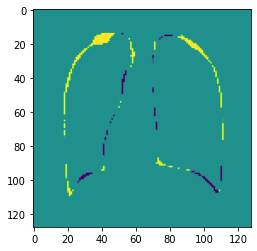

Difference between human-gen mask and model-gen mask with threshold = 0.5


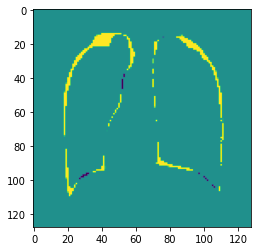

Difference between human-gen mask and model-gen mask with threshold = 0.2


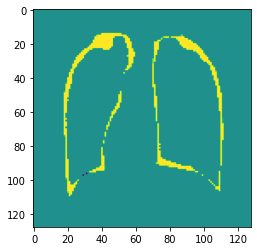

In [147]:
# plt.imshow(X_train[35])
# plt.show()

plt.imshow(Y_train[35])
plt.show()

theshold = 11
print(f"Difference between human-gen mask and model-gen mask with threshold = {theshold}")
plt.imshow(Y_train[35]-to_img_gen(X_train[35], loaded_model_better, theshold))
plt.show()

theshold = 8/10
print(f"Difference between human-gen mask and model-gen mask with threshold = {theshold}")
plt.imshow(Y_train[35]-to_img_gen(X_train[35], loaded_model_better, theshold))
plt.show()

theshold = 5/10
print(f"Difference between human-gen mask and model-gen mask with threshold = {theshold}")
plt.imshow(Y_train[35]-to_img_gen(X_train[35], loaded_model_better, theshold))
plt.show()

theshold = 2/10
print(f"Difference between human-gen mask and model-gen mask with threshold = {theshold}")
plt.imshow(Y_train[35]-to_img_gen(X_train[35], loaded_model_better, theshold))
plt.show()





# plt.imshow(to_img_gen(X_train[35], loaded_model_better, 1/2))
# plt.show()

# plt.imshow(to_img_gen(X_train[35], loaded_model, 1/2))
# plt.show()

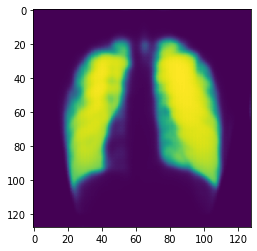

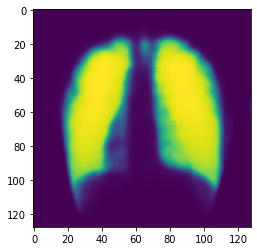

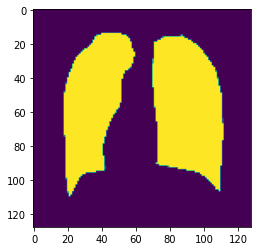

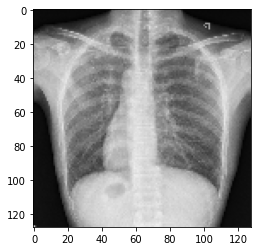

In [88]:
plt.imshow(to_img_gen(X_train[35]))
plt.show()

plt.imshow(to_img_gen(X_train[35], loaded_model))
plt.show()

plt.imshow(Y_train[35])
plt.show()

plt.imshow(X_train[35])
plt.show()

## computing 1+1 = 2

In [17]:
1+1

2

## (s)crap